# Titanic Dataset - Feature Engineering

**Student:** Arthur Gislon Leonida

**Objective:** This dataset aims to predict the survival of passengers on the Titanic.

**Dataset URL:** https://www.kaggle.com/competitions/titanic

**Data Dictionary:**

* **survival:** Survival (0 = No, 1 = Yes) - That's the **TARGET**

* **pclass:** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

* **sex:** Sex	

* **Age:** Age in years	

* **sibsp:** # of siblings / spouses aboard the Titanic	

* **parch:** # of parents / children aboard the Titanic	

* **ticket:**	Ticket number	

* **fare:** Passenger fare	

* **cabin:** Cabin number	

* **embarked:** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import shap
import ipykernel
from scipy.stats import boxcox
from helper_functions import adaptive_binning, robust_outlier_detection, mutual_information, hsic

print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)
print("numpy version:", np.__version__)
print("shap version:", shap.__version__)
print("ipykernel version:", ipykernel.__version__)
print('python version:', os.popen('python --version').read().strip())

pandas version: 2.3.2
matplotlib version: 3.10.5
seaborn version: 0.13.2
sklearn version: 1.7.1
xgboost version: 3.0.4
numpy version: 2.2.0
shap version: 0.48.0
ipykernel version: 6.30.1
python version: Python 3.13.7


In [2]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

In [3]:
# The downloaded dataset has a file named 'Salary Prediction of Data Professions.csv'
train_file_path = 'data/train.csv'
# test_file_path = 'data/test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(train_file_path)

# I won't use this because it doesn't have the target variable (it was made for kaggle competition)
# test_df = pd.read_csv(test_file_path)

In [4]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

print(f"Training set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")

Training set shape: (712, 12)
Validation set shape: (179, 12)


## Baseline Model

In [5]:
df_baseline = df_train.copy()

# Simple imputation and encoding
df_baseline['Age'] = df_baseline['Age'].fillna(df_baseline['Age'].median())
df_baseline['Embarked'] = df_baseline['Embarked'].fillna(df_baseline['Embarked'].mode()[0])
df_baseline['Sex'] = df_baseline['Sex'].map({'male': 0, 'female': 1})
df_baseline = pd.get_dummies(df_baseline, columns=['Embarked'], prefix='Emb', drop_first=True)

# Select only the most basic features
baseline_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_Q', 'Emb_S']
X_train_base = df_baseline[baseline_features]
y_train_base = df_baseline['Survived']

# Train baseline model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base, y_train_base)

# Prepare validation data for baseline
df_val_base = df_val.copy()
df_val_base['Age'] = df_val_base['Age'].fillna(df_train['Age'].median()) # Use train median to avoid leakage
df_val_base['Embarked'] = df_val_base['Embarked'].fillna(df_train['Embarked'].mode()[0]) # Use train mode
df_val_base['Sex'] = df_val_base['Sex'].map({'male': 0, 'female': 1})
df_val_base = pd.get_dummies(df_val_base, columns=['Embarked'], prefix='Emb', drop_first=True)
X_val_base = df_val_base[baseline_features]
y_val_base = df_val_base['Survived']

# Evaluate baseline
preds_base = baseline_model.predict(X_val_base)
baseline_accuracy = accuracy_score(y_val_base, preds_base)
print(f"\nTrue Baseline Model Accuracy: {baseline_accuracy:.4f}")


True Baseline Model Accuracy: 0.8156


# FEATURE ENGINEERING PIPELINE

Consolidate all feature engineering into a single, reusable function.


In [ ]:
def feature_engineer_complete(df, train_median_age, train_mode_embarked):
    df_eng = df.copy()

    # Imputation
    df_eng['Age'] = df_eng['Age'].fillna(train_median_age)
    df_eng['Embarked'] = df_eng['Embarked'].fillna(train_mode_embarked)
    df_eng['Fare'] = df_eng['Fare'].fillna(df_eng['Fare'].median())

    # Basic Features
    df_eng['FamilySize'] = df_eng['SibSp'] + df_eng['Parch'] + 1
    df_eng['IsAlone'] = (df_eng['FamilySize'] == 1).astype(int)
    df_eng['Title'] = df_eng['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False).apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
    df_eng['Deck'] = df_eng['Cabin'].str[0].fillna('U')

    # Transformations (abs, max)
    df_eng['Fare_from_mean'] = abs(df_eng['Fare'] - df_eng['Fare'].mean())
    df_eng['Max_SibSp_Parch'] = df_eng[['SibSp', 'Parch']].max(axis=1) # maximum value between the number of siblings/spouses (SibSp) and the number of parents/children (Parch) aboard for each passenger
    df_eng['Age*Pclass'] = df_eng['Age'] * df_eng['Pclass'] # capture interaction between age and passenger class
    
    # Skewness Transformations
    df_eng['Fare_log'] = np.log1p(df_eng['Fare'])
    
    # *** USE YOUR ADAPTIVE BINNING FUNCTION ***
    features_to_bin = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch', 
                       'Fare_from_mean', 'Max_SibSp_Parch', 'Age*Pclass']
    binned_columns = []
    for feature in features_to_bin:
        if feature in df_eng.columns:
            # Get optimal bin number using your adaptive function
            optimal_bins = adaptive_binning(df_eng[feature])
            
            # Create the new binned column name
            binned_col_name = f'{feature}_binned'
            
            # Create the binned feature
            df_eng[binned_col_name] = pd.cut(df_eng[feature], bins=optimal_bins, labels=False, duplicates='drop')
            binned_columns.append(binned_col_name)
            print(f"Binned '{feature}' into {optimal_bins} bins.")

    columns_to_encode = ['Sex', 'Embarked', 'Deck', 'Title'] + binned_columns
    df_eng = pd.get_dummies(df_eng, columns=columns_to_encode, drop_first=True)
    
    # Define all original and intermediate columns to be dropped
    columns_to_drop = [
        'PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'FamilySize', 'Age',
        'SibSp', 'Parch', 'Fare_from_mean', 'Max_SibSp_Parch', 'Age*Pclass'
    ]
    df_eng.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    return df_eng

In [8]:
# Now apply the full pipeline
X_train_eng = feature_engineer_complete(df_train.drop('Survived', axis=1), df_train['Age'].median(), df_train['Embarked'].mode()[0])
y_train_eng = df_train['Survived']
X_val_eng = feature_engineer_complete(df_val.drop('Survived', axis=1), df_train['Age'].median(), df_train['Embarked'].mode()[0])
y_val_eng = df_val['Survived']

Binned 'Age' into 2 bins.
Binned 'Fare' into 2 bins.
Binned 'FamilySize' into 9 bins.
Binned 'SibSp' into 7 bins.
Binned 'Parch' into 7 bins.
Binned 'Fare_from_mean' into 2 bins.
Binned 'Max_SibSp_Parch' into 8 bins.
Binned 'Age*Pclass' into 2 bins.
Binned 'Age' into 21 bins.
Binned 'Fare' into 35 bins.
Binned 'FamilySize' into 9 bins.
Binned 'SibSp' into 7 bins.
Binned 'Parch' into 3 bins.
Binned 'Fare_from_mean' into 35 bins.
Binned 'Max_SibSp_Parch' into 7 bins.
Binned 'Age*Pclass' into 8 bins.


## Why the code below is necessary:

* When I use pd.get_dummies (one-hot encoding) on my training and validation sets separately, they might end up with a different number of columns.

* Example: if a rare Title like 'Dr' only appears in my training data, the Title_Dr column will be created in X_train_eng but not in X_val_eng.

In [9]:
# === Align Columns After Feature Engineering ===

# Identify the columns from the fully engineered training set
train_cols = X_train_eng.columns
val_cols = X_val_eng.columns

# Find columns that are in the training set but not in the validation set
# This can happen if a certain category (e.g., a rare 'Title' or 'Deck') 
# exists in the training data but not in the validation split.
missing_in_val = set(train_cols) - set(val_cols)

# Add the missing columns to the validation set and fill them with 0
for c in missing_in_val:
    X_val_eng[c] = 0
    print(f"Added missing column to validation set: {c}")

# Find columns that are in the validation set but not in the training set
# This is rarer but can happen with certain data splits.
missing_in_train = set(val_cols) - set(train_cols)
for c in missing_in_train:
    # We would drop these from the validation set as the model has never seen them
    X_val_eng.drop(c, axis=1, inplace=True)
    print(f"Dropped extra column from validation set: {c}")


# Ensure the order of columns in the validation set is identical to the training set
X_val_eng = X_val_eng[train_cols]

print("\nColumn alignment complete.")

Added missing column to validation set: Parch_binned_5
Added missing column to validation set: Parch_binned_3
Added missing column to validation set: Parch_binned_6
Added missing column to validation set: Parch_binned_4
Added missing column to validation set: Max_SibSp_Parch_binned_5
Added missing column to validation set: Deck_T
Added missing column to validation set: Max_SibSp_Parch_binned_7
Added missing column to validation set: Age_binned_1
Added missing column to validation set: Deck_G
Dropped extra column from validation set: Age_binned_13
Dropped extra column from validation set: Age_binned_2
Dropped extra column from validation set: Age*Pclass_binned_7
Dropped extra column from validation set: Fare_from_mean_binned_6
Dropped extra column from validation set: Age*Pclass_binned_2
Dropped extra column from validation set: Fare_from_mean_binned_12
Dropped extra column from validation set: Age*Pclass_binned_5
Dropped extra column from validation set: Fare_from_mean_binned_2
Dropped

## Feature Selection

In [10]:
df_selection = X_train_eng.copy()
y_selection = y_train_eng.copy()

# Calculate scores
mi_scores = df_selection.apply(lambda x: mutual_information(x, y_selection), axis=0)
hsic_scores = df_selection.apply(lambda x: hsic(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)
k = 20
top_mi = scores_df['MI'].nlargest(k).index
top_hsic = scores_df['HSIC'].nlargest(k).index
final_features = list(set(top_mi) | set(top_hsic))
print(f"Selected {len(final_features)} features after voting:")
print(final_features)

Selected 20 features after voting:
['Deck_U', 'Fare_log', 'Age*Pclass_binned_1', 'Deck_C', 'Deck_E', 'FamilySize_binned_1', 'Parch_binned_2', 'Pclass', 'Deck_B', 'Deck_D', 'FamilySize_binned_2', 'FamilySize_binned_4', 'Sex_male', 'Title_Mrs', 'Title_Miss', 'Parch_binned_1', 'Max_SibSp_Parch_binned_1', 'Embarked_S', 'IsAlone', 'Title_Mr']


## Final Modeling and SHAP

In [11]:
# 1. Select the top-k features AND create an explicit copy
X_train_final = X_train_eng[final_features].copy()
y_train_final = y_train_eng.copy()

X_val_final = X_val_eng[final_features].copy()
y_val_final = y_val_eng.copy()

# 2. Convert boolean columns to integers
# This part of your code no longer needs to be changed
bool_cols = X_train_final.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print(f"Converting boolean columns: {list(bool_cols)}")
    for col in bool_cols:
        X_train_final[col] = X_train_final[col].astype(int)
        X_val_final[col] = X_val_final[col].astype(int)
    print("Boolean columns converted to integers.")

X_train_final.info()

Converting boolean columns: ['Deck_U', 'Age*Pclass_binned_1', 'Deck_C', 'Deck_E', 'FamilySize_binned_1', 'Parch_binned_2', 'Deck_B', 'Deck_D', 'FamilySize_binned_2', 'FamilySize_binned_4', 'Sex_male', 'Title_Mrs', 'Title_Miss', 'Parch_binned_1', 'Max_SibSp_Parch_binned_1', 'Embarked_S', 'Title_Mr']
Boolean columns converted to integers.
<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Deck_U                    712 non-null    int64  
 1   Fare_log                  712 non-null    float64
 2   Age*Pclass_binned_1       712 non-null    int64  
 3   Deck_C                    712 non-null    int64  
 4   Deck_E                    712 non-null    int64  
 5   FamilySize_binned_1       712 non-null    int64  
 6   Parch_binned_2            712 non-null    int64  
 7   Pclass                    712 non-null    int64  
 8   Deck

In [12]:
X_train_final.head(5)

,Deck_U,Fare_log,Age*Pclass_binned_1,Deck_C,Deck_E,FamilySize_binned_1,Parch_binned_2,Pclass,Deck_B,Deck_D,FamilySize_binned_2,FamilySize_binned_4,Sex_male,Title_Mrs,Title_Miss,Parch_binned_1,Max_SibSp_Parch_binned_1,Embarked_S,IsAlone,Title_Mr
692,1,4.051712,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,1,1,1
481,1,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,1,1
527,0,5.406181,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1
855,1,2.336987,0,0,0,0,0,3,0,0,0,0,0,1,0,1,0,1,0,0
801,1,3.305054,0,0,0,1,0,2,0,0,0,0,0,1,0,1,0,1,0,0


c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:19:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Comparison ---
Baseline Model Accuracy: 0.8156
Final Model Accuracy:    0.7542
------------------------------------

SHAP Summary Plot (Top 15 Features):


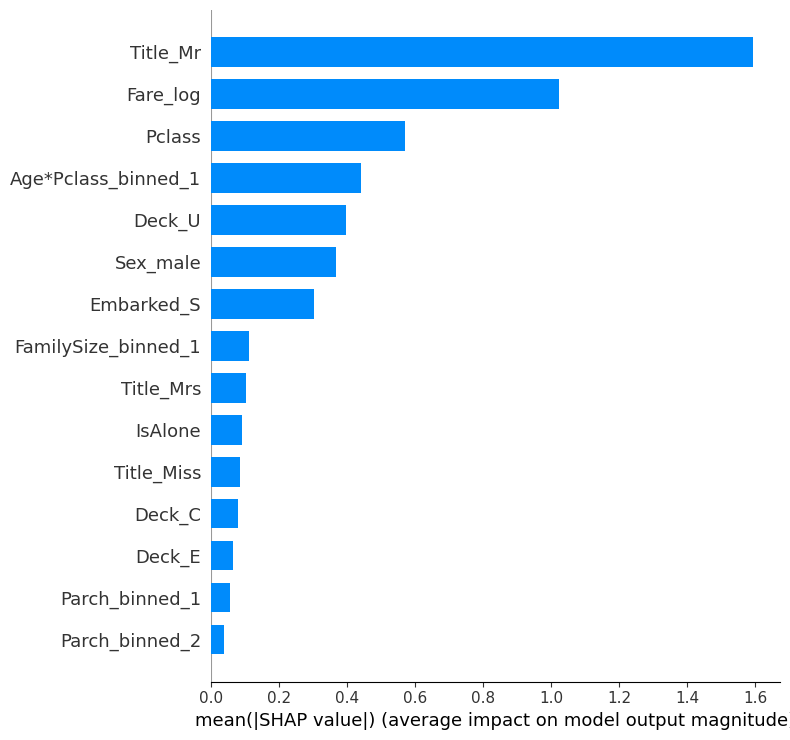

In [13]:
final_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
'''
final_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,  # Limit tree depth to prevent overfitting
    gamma=0.1      # Add a regularization term
)
'''
final_model.fit(X_train_final, y_train_final)
preds_final = final_model.predict(X_val_final)
final_accuracy = accuracy_score(y_val_final, preds_final)

print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {final_accuracy:.4f}")
print("------------------------------------")

explainer = shap.Explainer(final_model, X_train_final)
shap_values = explainer(X_val_final)
print("\nSHAP Summary Plot (Top 15 Features):")
shap.summary_plot(shap_values, X_val_final, plot_type="bar", max_display=15)

# CHECK THIS

In [ ]:
df_eng = df.copy()

# --- Foundational Features ---
df_eng['FamilySize'] = df_eng['SibSp'] + df_eng['Parch'] + 1
df_eng['IsAlone'] = (df_eng['FamilySize'] == 1).astype(int)

# --- Transformation & Interaction Features ---
df_eng['Age*Pclass'] = df_eng['Age'] * df_eng['Pclass'] # capture interaction between age and passenger class
df_eng.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Age*Pclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,66.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,78.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,105.0


In [ ]:
train_df_eng = df_eng.copy().drop(columns=['Survived'])
print(train_df_eng.columns.to_list().__len__())
print(df_eng.columns.to_list().__len__())
train_df_eng.head(5)

14
15


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Age*Pclass
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,66.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,38.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,78.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,35.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,105.0


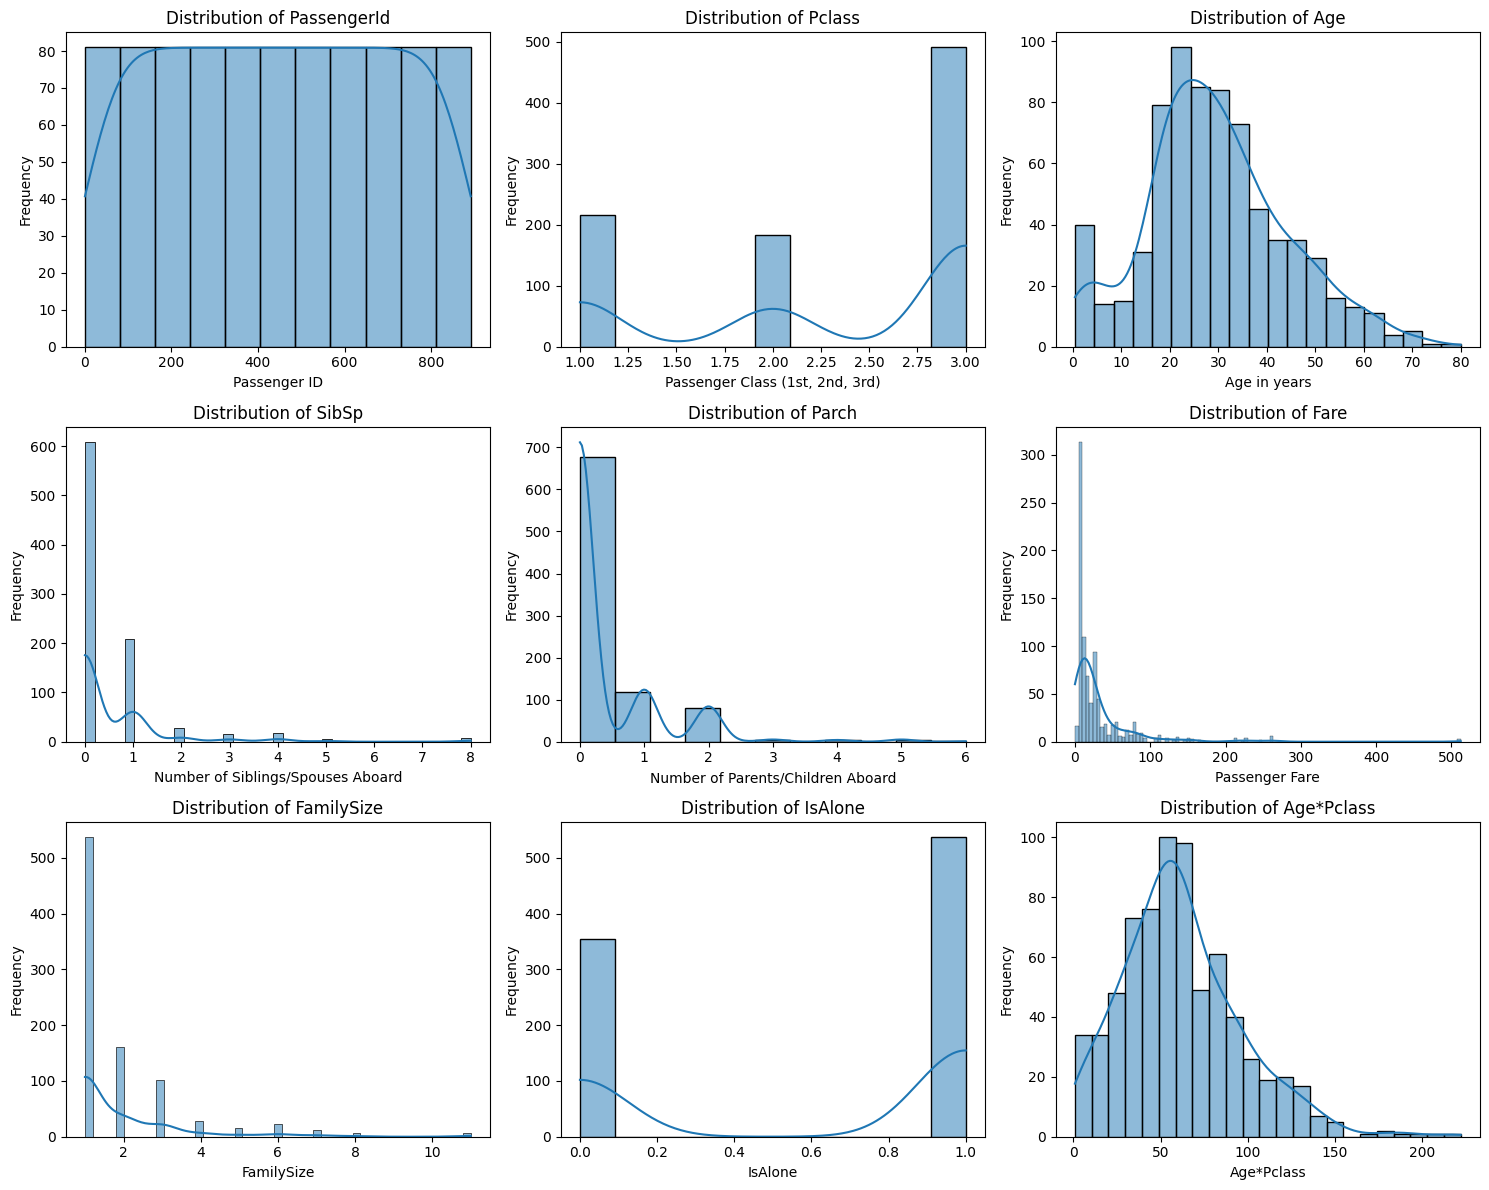

In [ ]:
numeric_features = train_df_eng.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 3
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(train_df_eng[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Checking and dealing with skewness

Image from professor **Laio O. Seman:**

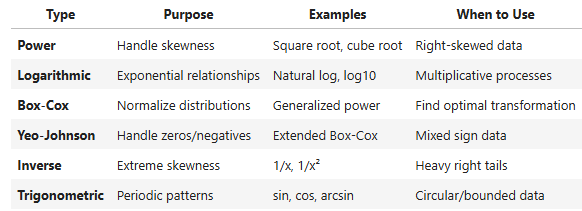

In [ ]:
numerical_features = df_eng.select_dtypes(include=np.number).columns
skewness = df_eng[numerical_features].skew().sort_values(ascending=False)

print("Skewness of Numerical Features:")
print(skewness)

# Identify highly skewed features
highly_skewed = skewness[abs(skewness) > 0.5]
print("\nFeatures with significant skew:")
print(highly_skewed)

Skewness of Numerical Features:
Fare           4.787317
SibSp          3.695352
Parch          2.749117
FamilySize     2.727441
Age*Pclass     0.840801
Survived       0.478523
Age            0.389108
PassengerId    0.000000
IsAlone       -0.420431
Pclass        -0.630548
dtype: float64

Features with significant skew:
Fare          4.787317
SibSp         3.695352
Parch         2.749117
FamilySize    2.727441
Age*Pclass    0.840801
Pclass       -0.630548
dtype: float64


**OBS:** Sex, Embarked, Title, IsAlone, Pclass and CabinDeck are categorical but encoded as numbers, so I won't transform them.

**Features that makes sense to apply transformation:** Age, SibSp, Parch, Fare, FamilySize, Age*Pclass, TicketLength, CabinCount

* **Fare (Highly Skewed):** Box-Cox is the ideal choice here because it's data-driven.
* **FamilySize, SibSp, Parch (Right-Skewed Counts):** For count data, the log transform is the standard and most effective method.
* **Age and Age*Pclass (Moderately Right-Skewed):** A milder transformation like the square root transform (np.sqrt) is often sufficient for moderately skewed data.

**References:** 

* https://anatomisebiostats.com/biostatistics-blog/transforming-skewed-data/
* https://medium.com/@lamunozs/dealing-with-high-skewed-data-a-practical-guide-part-iii-19fc38a10a7c

In [ ]:
# --- Handle Skewness in Key Numerical Features ---
from scipy.stats import boxcox

# Apply Box-Cox to Fare (add 1 to handle zero fares)
df_eng['Fare_boxcox'], _ = boxcox(df_eng['Fare'] + 1)

# Apply Log Transform to count-based features
df_eng['FamilySize_log'] = np.log1p(df_eng['FamilySize'])
df_eng['SibSp_log'] = np.log1p(df_eng['SibSp'])
df_eng['Parch_log'] = np.log1p(df_eng['Parch'])

# Apply Square Root Transform to moderately skewed features
# Ensure the column exists and handle potential NaNs before transforming
if 'Age' in df_eng.columns:
    df_eng['Age_sqrt'] = np.sqrt(df_eng['Age'].fillna(df_eng['Age'].median()))
if 'Age*Pclass' in df_eng.columns:
    df_eng['Age*Pclass_sqrt'] = np.sqrt(df_eng['Age*Pclass'].fillna(df_eng['Age*Pclass'].median()))


# --- Drop the Original Skewed Columns ---
# Now that we have the transformed versions, we can drop the originals
# to avoid multicollinearity.
features_to_drop = ['Fare', 'FamilySize', 'SibSp', 'Parch']
if 'Age' in df_eng.columns:
    features_to_drop.append('Age')
if 'Age*Pclass' in df_eng.columns:
    features_to_drop.append('Age*Pclass')
    
df_eng.drop(columns=features_to_drop, inplace=True)

print("Applied transformations and dropped original skewed columns.")
print("New DataFrame columns:", df_eng.columns)

Applied transformations and dropped original skewed columns.
New DataFrame columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin',
       'Embarked', 'IsAlone', 'Fare_boxcox', 'FamilySize_log', 'SibSp_log',
       'Parch_log', 'Age_sqrt', 'Age*Pclass_sqrt'],
      dtype='object')


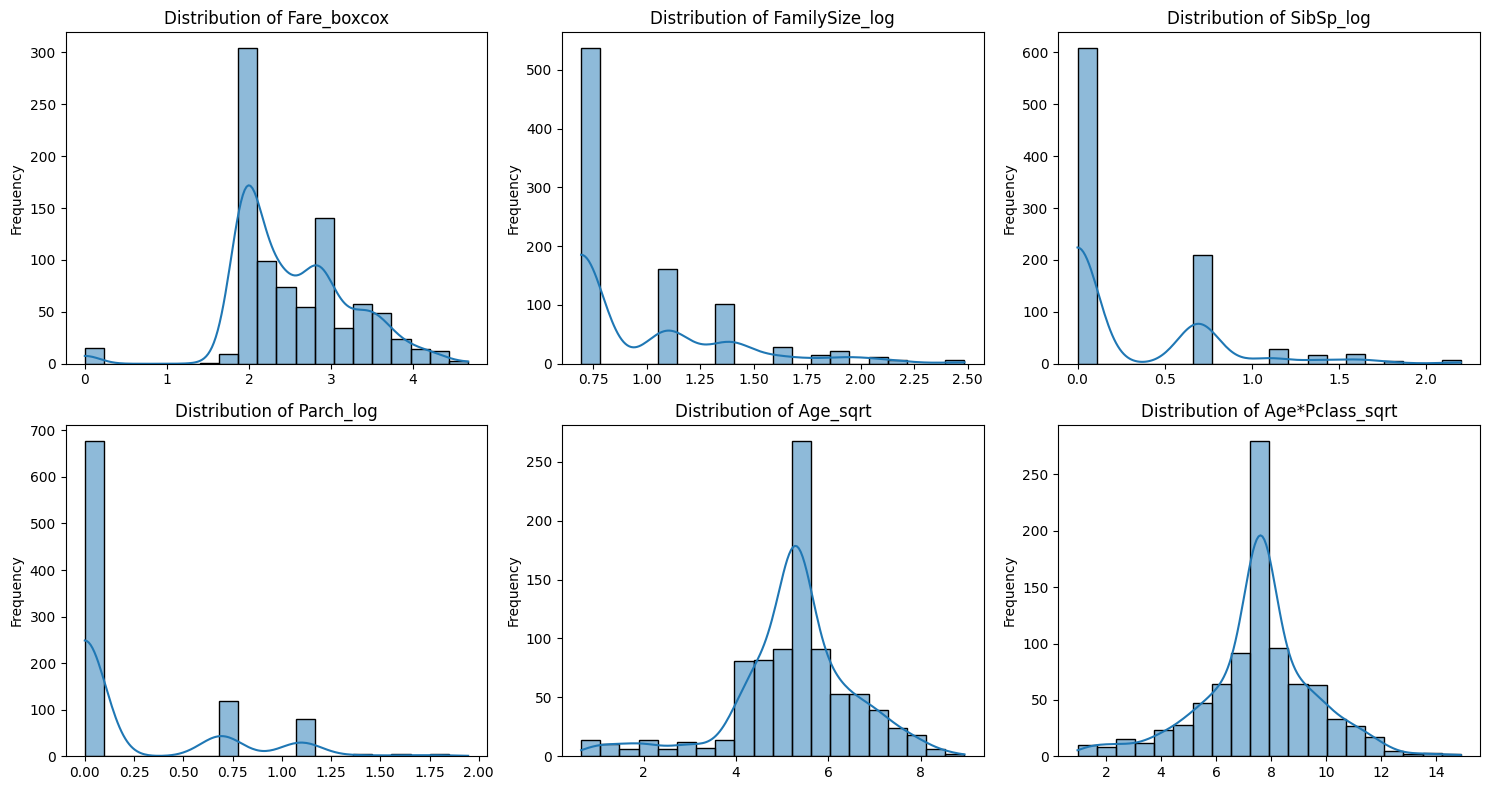

In [ ]:
# --- Visualize All Transformed Features ---

# List the names of your new, transformed columns
transformed_features = [
    'Fare_boxcox', 
    'FamilySize_log', 
    'SibSp_log', 
    'Parch_log', 
    'Age_sqrt', 
    'Age*Pclass_sqrt'
]

# Create a figure and a grid of subplots
# We'll do a 2x3 grid to fit all 6 plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten() # Flatten the 2x3 grid into a 1D array for easy looping

for i, feature in enumerate(transformed_features):
    if feature in df_eng.columns: # Check if the feature exists
        sns.histplot(df_eng[feature], kde=True, ax=axes[i], bins=20)
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel('') # Optional: remove x-label for cleaner look
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()
plt.show()

### Check for outliers

* Here, I'll apply Winsorizing to handle outliers, I'll use the `robust_outlier_detection()` function from the professor Laio O. Seman to detect outliers.

Why Multiple Methods?

* Robustness: No single method works for all distributions
* Confidence: Multiple methods agreeing = higher confidence
* Different sensitivity: Catch different types of anomalies

In [ ]:
for feature in df_eng.select_dtypes(include=['number']).columns:
    outliers = robust_outlier_detection(df_eng[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Feature "Fare_boxcox" has 15 outliers detected.
Feature "FamilySize_log" has 13 outliers detected.
Feature "SibSp_log" has 12 outliers detected.
Feature "Parch_log" has 10 outliers detected.
Feature "Age_sqrt" has 14 outliers detected.
Feature "Age*Pclass_sqrt" has 9 outliers detected.


In [ ]:
# --- Capping Outliers using the Percentile Method ---

# Create a temporary DataFrame to show the 'before' state
temp_df = df.copy()

# Focus on the true numerical/continuous features from the list.
features_to_cap = [
    'Fare_boxcox', 
    'FamilySize_log', 
    'SibSp_log', 
    'Parch_log', 
    'Age_sqrt', 
    'Age*Pclass_sqrt'
]

for feature in features_to_cap:
    if feature in df_eng.columns:
        # Define the lower and upper bounds for capping
        lower_bound = df_eng[feature].quantile(0.05)
        upper_bound = df_eng[feature].quantile(0.95)
        
        print(f'Capping outliers in "{feature}" between {lower_bound:.2f} and {upper_bound:.2f}')
        
        # Use np.clip to cap the values
        df_eng[feature] = np.clip(df_eng[feature], lower_bound, upper_bound)

Capping outliers in "Fare_boxcox" between 1.90 and 3.79
Capping outliers in "FamilySize_log" between 0.69 and 1.95
Capping outliers in "SibSp_log" between 0.00 and 1.39
Capping outliers in "Parch_log" between 0.00 and 1.10
Capping outliers in "Age_sqrt" between 2.45 and 7.35
Capping outliers in "Age*Pclass_sqrt" between 3.81 and 10.95


C:\Users\arthu\AppData\Local\Temp\ipykernel_19444\201278901.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_df['Fare'].fillna(temp_df['Fare'].median(), inplace=True)


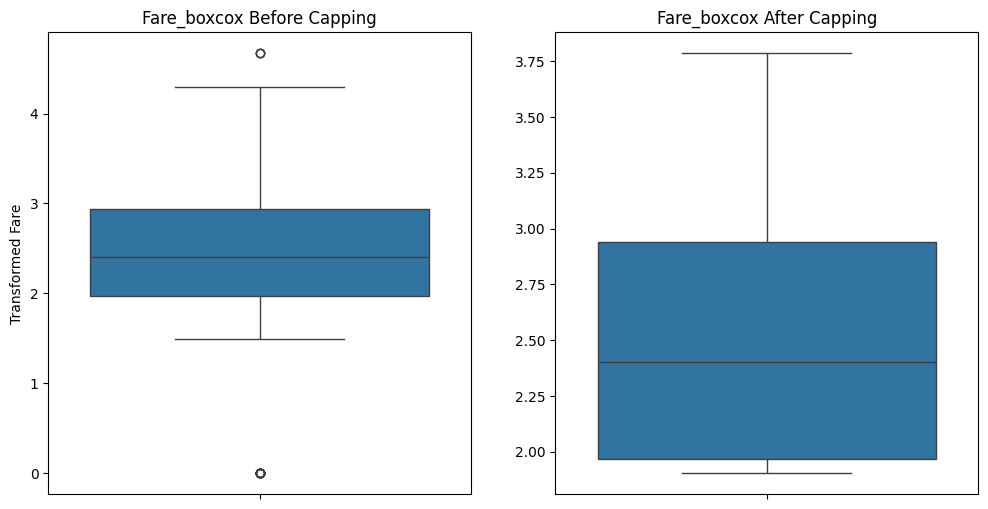

In [ ]:
# --- Visualize the Effect of Capping on 'Fare_boxcox' ---
temp_df['Fare'].fillna(temp_df['Fare'].median(), inplace=True)
temp_df['Fare_boxcox'], _ = boxcox(temp_df['Fare'] + 1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before Capping
sns.boxplot(y=temp_df['Fare_boxcox'], ax=axes[0])
axes[0].set_title('Fare_boxcox Before Capping')
axes[0].set_ylabel('Transformed Fare')

# After Capping
sns.boxplot(y=df_eng['Fare_boxcox'], ax=axes[1])
axes[1].set_title('Fare_boxcox After Capping')
axes[1].set_ylabel('') # Hide redundant y-label

plt.show()

## Binning, MI, HSIC

In [ ]:
from helper_functions import mutual_information, hsic, adaptive_binning

# --- Find and Apply Optimal Bins for Age and Fare ---
# We use the imputed and transformed features as input
optimal_age_bins = adaptive_binning(df_eng['Age_sqrt'])
optimal_fare_bins = adaptive_binning(df_eng['Fare_boxcox'])

print(f"Optimal number of bins for 'Age_sqrt': {optimal_age_bins}")
print(f"Optimal number of bins for 'Fare_boxcox': {optimal_fare_bins}")

# --- Create the Final Binned Features ---
df_eng['Age_binned'] = pd.cut(df_eng['Age_sqrt'], bins=optimal_age_bins, labels=False, duplicates='drop')
df_eng['Fare_binned'] = pd.cut(df_eng['Fare_boxcox'], bins=optimal_fare_bins, labels=False, duplicates='drop')

# --- One-Hot Encode the New Binned Features ---
df_eng = pd.get_dummies(df_eng, columns=['Age_binned', 'Fare_binned'], prefix=['AgeBin', 'FareBin'])

# Now that you have optimally binned features, drop the intermediate ones
df_eng.drop(['Age_sqrt', 'Fare_boxcox'], axis=1, inplace=True)

print("\nCreated and encoded new features from adaptive binning.")

Optimal number of bins for 'Age_sqrt': 2
Optimal number of bins for 'Fare_boxcox': 2

Created and encoded new features from adaptive binning.


In [ ]:
# Cell: Feature Selection
df_selection = df_eng.copy().dropna()
y_selection = df_selection['Survived']
X_selection = df_selection.drop('Survived', axis=1)

# Calculate scores using your MI and HSIC functions
mi_scores = X_selection.apply(lambda x: mutual_information(x, y_selection), axis=0)
hsic_scores = X_selection.apply(lambda x: hsic(x, y_selection), axis=0)

# Create a summary DataFrame and select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)
k = 20
top_mi = scores_df['MI'].nlargest(k).index
top_hsic = scores_df['HSIC'].nlargest(k).index

final_features = list(set(top_mi) | set(top_hsic))
print(f"Selected {len(final_features)} features after voting:")
print(final_features)

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metric

ValueError: could not convert string to float: 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'

In [ ]:
# Final Modeling and SHAP
X_final = df_eng[final_features]
y_final = df_eng['Survived']
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Identify columns with the boolean dtype
bool_cols = X_train_final.select_dtypes(include=['bool']).columns

# Convert these columns to integers (0 and 1) in both datasets
for col in bool_cols:
    X_train_final[col] = X_train_final[col].astype(int)
    X_val_final[col] = X_val_final[col].astype(int)

print("Boolean columns converted to integers.")

X_train_final.info()

Boolean columns converted to integers.
<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CabinCount       712 non-null    int64  
 1   FareBin_0        712 non-null    int64  
 2   IsAlone          712 non-null    int64  
 3   SibSp_log        712 non-null    float64
 4   Sex              712 non-null    int64  
 5   TicketLength     712 non-null    int64  
 6   AgeBin_1         712 non-null    int64  
 7   Title            712 non-null    int8   
 8   Parch_log        712 non-null    float64
 9   Pclass           712 non-null    int64  
 10  FareBin_1        712 non-null    int64  
 11  TicketPrefix     712 non-null    int8   
 12  CabinDeck        712 non-null    int8   
 13  Age*Pclass_sqrt  712 non-null    float64
 14  Embarked         712 non-null    float64
 15  FamilySize_log   712 non-null    float64
 16  AgeBin_0         712 non-n


--- Model Performance Comparison ---
Baseline Model Accuracy: 0.8156
Final Model Accuracy:    0.8101
------------------------------------

SHAP Summary Plot (Top 15 Features):


c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:17:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


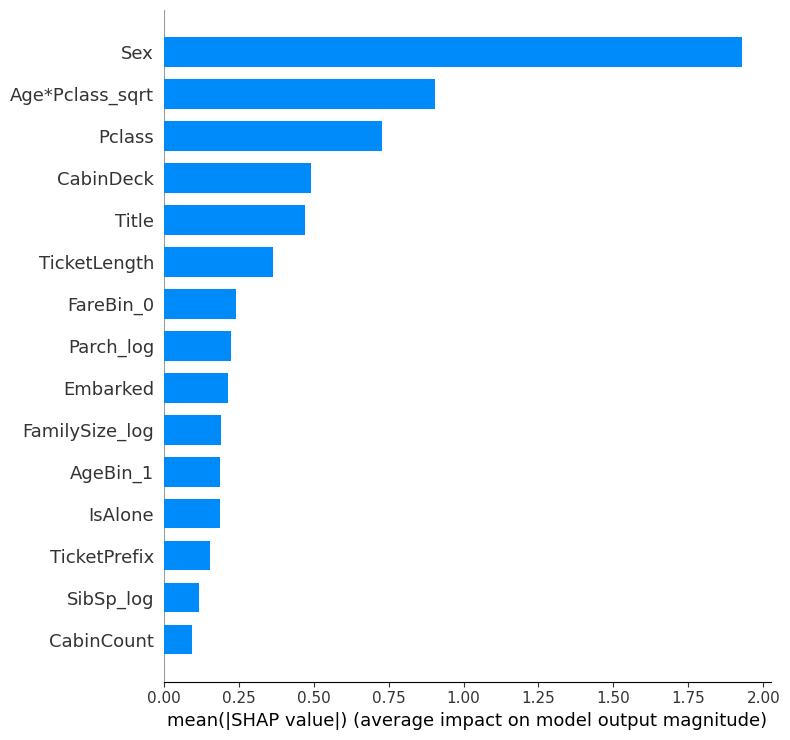

In [ ]:
final_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
'''
final_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,  # Limit tree depth to prevent overfitting
    gamma=0.1      # Add a regularization term
)
'''
final_model.fit(X_train_final, y_train_final)
preds_final = final_model.predict(X_val_final)
final_accuracy = accuracy_score(y_val_final, preds_final)

print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {final_accuracy:.4f}")
print("------------------------------------")

explainer = shap.Explainer(final_model, X_train_final)
shap_values = explainer(X_val_final)
print("\nSHAP Summary Plot (Top 15 Features):")
shap.summary_plot(shap_values, X_val_final, plot_type="bar", max_display=15)

In [ ]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(df_eng.drop(columns=['Survived']), df_eng['Survived'], test_size=0.2, random_state=42)